## Technical Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
# plt.rc("figure", figsize=(16, 4))


**Check core library versions used in the recipe**
* if using **Colab** ensure the versions are the same. If needed to update use
```shell
!pip install <library_name> -U
```

In [2]:
import sktime
import statsmodels as sm
import matplotlib 
import scipy 

print(f'''
sktime ->  {sktime.__version__}
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
scipy -> {scipy.__version__}
statsmodels -> {sm.__version__}
''')


sktime ->  0.11.0
Matplotlib -> 3.5.1
pandas -> 1.4.2   
numpy -> 1.21.5
scipy -> 1.7.3
statsmodels -> 0.13.2



In [2]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [14, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [7]:
path = Path('../../datasets/Ch13/')
# Read the daily_weather.csv 

daily_weather = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)
daily_weather.columns = ['y']
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['y']

air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)
air.columns = ['y']

In [8]:
daily_weather.index.freq = 'D'
energy.index.freq = 'MS'
air.index.freq = 'M'

In [9]:
print(daily_weather.index.freq)
print(energy.index.freq)
print(air.index.freq)

<Day>
<MonthBegin>
<MonthEnd>


<AxesSubplot:title={'center':'Monthly Passengers'}, xlabel='date'>

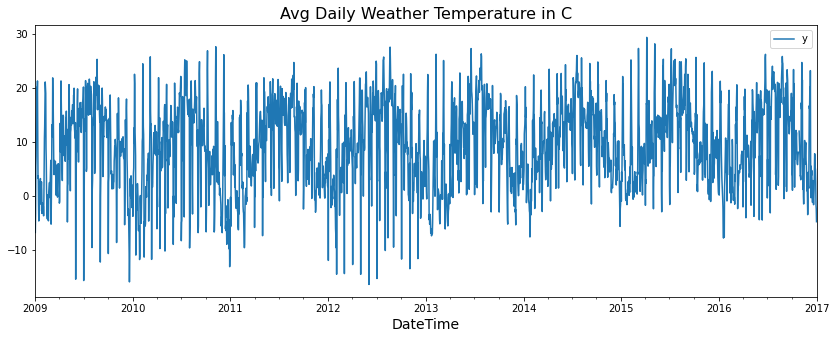

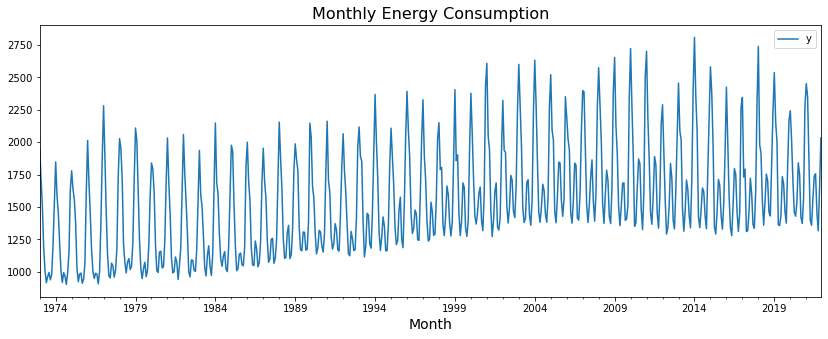

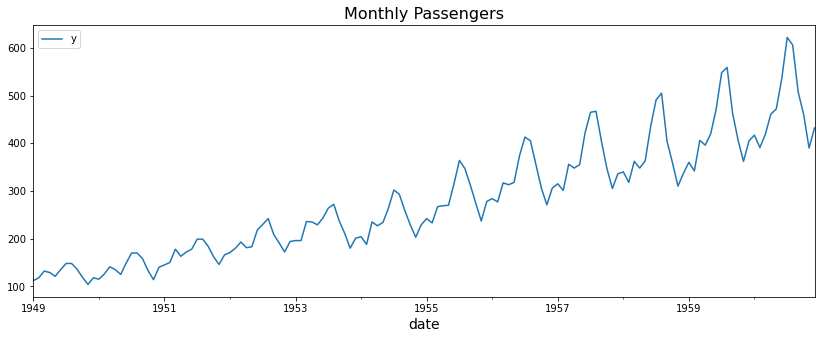

In [10]:
daily_weather.plot(title='Avg Daily Weather Temperature in C')
energy.plot(title='Monthly Energy Consumption')
air.plot(title='Monthly Passengers')

# Preparing Time Series for Supervised Machine Learning

In [11]:
air_reg = air.copy()
energy_reg = energy.copy()
daily_weather_reg = daily_weather.copy()

In [12]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)

In [13]:
for df in [air_reg, energy_reg, daily_weather_reg]:
    df = handle_missing_data(df)

found 2 missing observations...


In [15]:
daily_weather_reg.isna().sum()

y    0
dtype: int64

In [16]:
air_reg.head(6)

,y
date,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121
1949-06-30,135


In [ ]:
def window_slide(df, window):
    
    x = []
    indx = df.index[window:]
    for idx in range(len(df) - window):
        x.append(df[idx:idx + window])
    x = np.array(x)
    # print(x.shape)
    return x

In [21]:
air_reg.iloc[1:6]

,y
date,
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121
1949-06-30,135


In [51]:
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    return pd.concat([df, df_xs], axis=1).dropna()

In [52]:
air_os = one_step_forecast(air_reg, 5)
energy_os = one_step_forecast(energy_reg, 5)
daily_weather_os = one_step_forecast(daily_weather_reg, 5)
print(air_os.shape)
print(energy_os.shape)
print(daily_weather_os.shape)

(139, 6)
(583, 6)
(2918, 6)


In [53]:
air_os.head()

,y,x_1,x_2,x_3,x_4,x_5
date,,,,,,
1949-01-31,112,112.0,118.0,132.0,129.0,121.0
1949-02-28,118,118.0,132.0,129.0,121.0,135.0
1949-03-31,132,132.0,129.0,121.0,135.0,148.0
1949-04-30,129,129.0,121.0,135.0,148.0,148.0
1949-05-31,121,121.0,135.0,148.0,148.0,136.0


In [116]:
n = int(len(df_diff) * 0.1)
n

57

In [117]:
def split_data(df, test_split=0.15):

    train_lr = df_diff[:-n]
    test_lr = df_diff[-n:]

    x_train, y_train = train_lr.drop(columns=['y']), train_lr['y']
    x_test, y_test = test_lr.drop(columns=['y']), test_lr['y']

In [118]:
train_lr.shape

(519, 13)

In [119]:
x_train.shape

(519, 12)

In [120]:
test_lr.shape

(57, 13)

# Forecasting using Linear Regression Models with Scikit-Learn

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
from sklearn.linear_model import( LinearRegression, 
                                 ElasticNet, 
                                 Ridge, 
                                 Lasso, 
                                 HuberRegressor)
from statsmodels.tsa.api import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



In [186]:
# file = Path('../../datasets/Ch12/Residential_Energy_Consumption.xlsx')
# col = ['Month','Total Energy Consumed by the Residential Sector']
# df = pd.read_excel(file, index_col='Month', usecols=col)
# df.columns = ['y']
# df.plot()
# plt.savefig(f'../../../Packt-Time-Series-Cookbook/Chapters/Ch12/images/fig12.4.png', bbox_inches='tight', dpi=600)

In [6]:
df_diff = df.diff(1).dropna()
"Stationary" if adfuller(df_diff)[1] < 0.05 else "Non-Stationary"

'Stationary'

<AxesSubplot:xlabel='Month'>

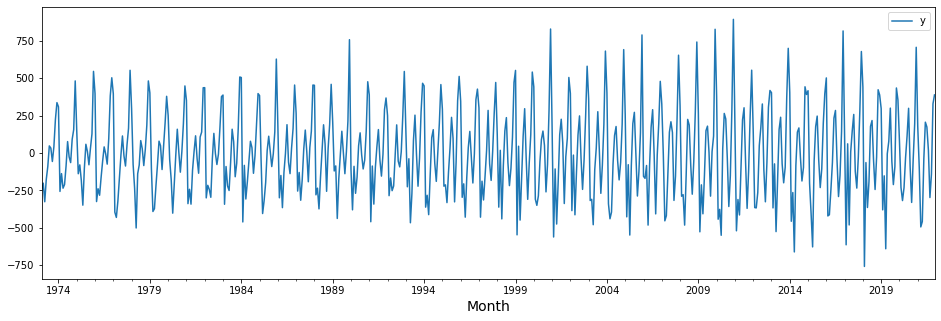

In [7]:
df_diff.plot()

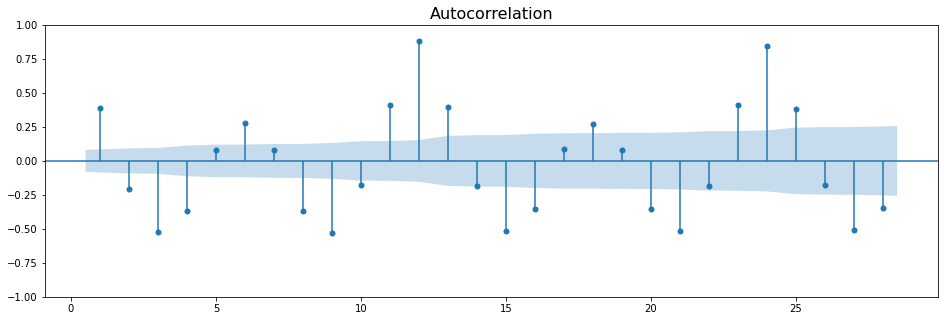

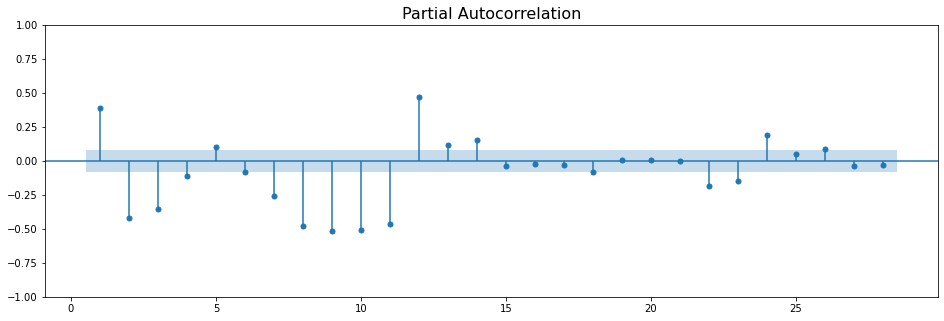

In [8]:
plot_acf(df_diff, zero=False);plt.show()
plot_pacf(df_diff, zero=False); plt.show()

In [121]:
from sklearn.metrics import mean_squared_error as mse

In [122]:
lr = LinearRegression()
en = ElasticNet()
rr = Ridge()
lsr = Lasso()
hr = HuberRegressor()

regressors = {
    'Linear Regression': LinearRegression(),
    'Elastic Net': ElasticNet(0.01),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(0.001),
    'Huber Regression': HuberRegressor(epsilon=2)
}

In [123]:
results = {}
for name, regressor in regressors.items():
    print(name)
    model = regressor
    model.fit(x_train, y_train)
    y_hat_test = model.predict(x_test)
    y_hat_train = model.predict(x_train)
    rmse_test = np.sqrt(mse(y_test, y_hat_test))
    rmse_train = np.sqrt(mse(y_train, y_hat_train))
    results[name] = {
        'model': model,
        'rmse test': rmse_test,
        'rmse train': rmse_train
    }
    
    

Linear Regression
Elastic Net
Ridge Regression
Lasso Regression
Huber Regression


In [124]:
r = results['Ridge Regression']['model']
r.coef_

array([ 0.58146786,  0.15515494,  0.03202699, -0.00866025, -0.06816663,
        0.04656024, -0.02573453,  0.06080519, -0.05112118,  0.0182035 ,
       -0.1452932 ,  0.37395411])

In [125]:
pd.DataFrame(results)

,Linear Regression,Elastic Net,Ridge Regression,Lasso Regression,Huber Regression
model,LinearRegression(),ElasticNet(alpha=0.01),Ridge(),Lasso(alpha=0.001),HuberRegressor(epsilon=2)
rmse test,121.332579,121.332519,121.332577,121.332568,121.506145
rmse train,106.69697,106.69697,106.69697,106.69697,107.869504


In [126]:
for i in results:
    print(i)

Linear Regression
Elastic Net
Ridge Regression
Lasso Regression
Huber Regression


Linear Regression
12


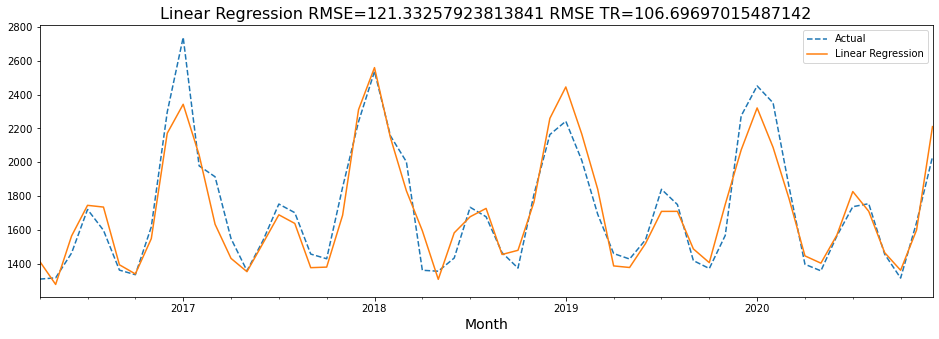

Elastic Net
12


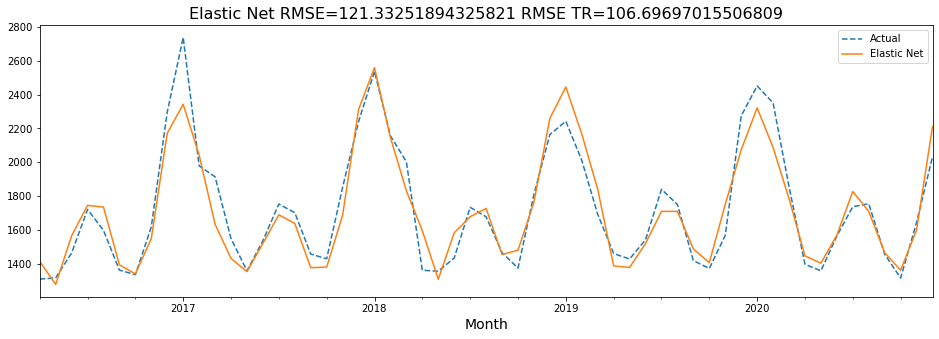

Ridge Regression
12


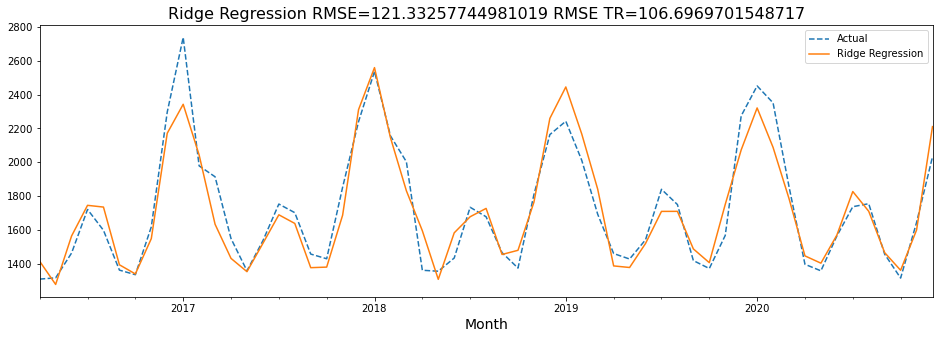

Lasso Regression
12


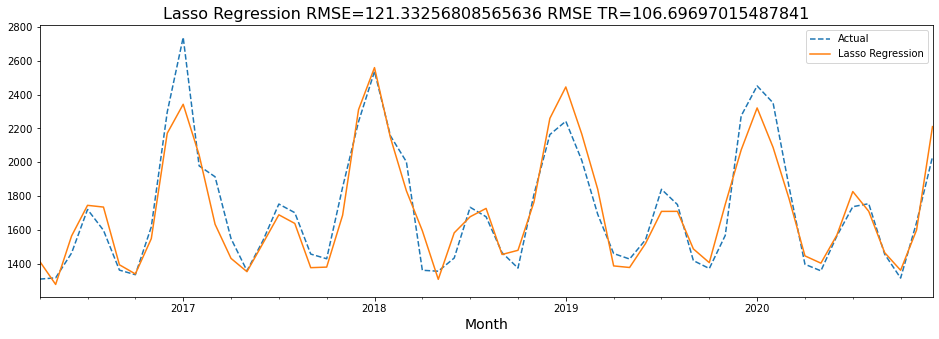

Huber Regression
12


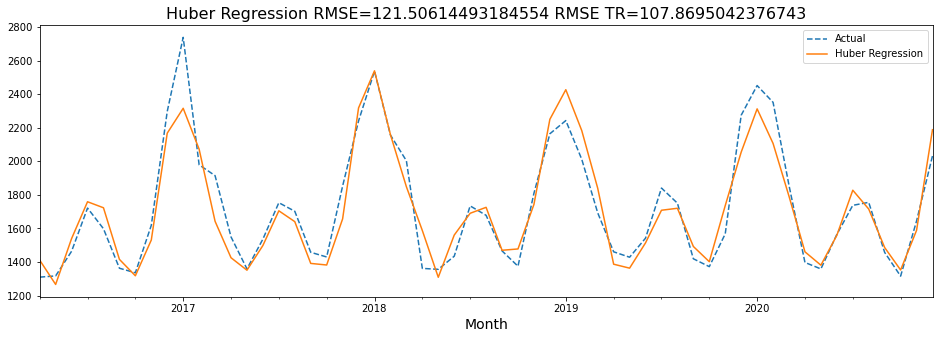

In [127]:
for models in results:
    lr = results[models]['model']
    rmse = results[models]['rmse test']
    rmse_tr = results[models]['rmse train']
    print(models)
    y_hat = pd.Series(lr.predict(x_test), index=x_test.index)
    y_hat_tr = pd.Series(lr.predict(x_train), index=x_train.index)
    print(len(lr.coef_))

    ax = y_test.plot(style='--', title=f'{models} RMSE={rmse} RMSE TR={rmse_tr}')
    y_hat.plot(ax=ax)
    plt.legend(['Actual', models])
    #plt.savefig(f'../../../Packt-Time-Series-Cookbook/Chapters/Ch12/images/fig12.7.png', bbox_inches='tight', dpi=600)
    plt.show()

In [128]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

rf = RandomForestRegressor()
svr = SVR(kernel='linear')
knn = KNeighborsRegressor()

rf.fit(x_train, y_train)
svr.fit(x_train, y_train)
knn.fit(x_train, y_train)

KNeighborsRegressor()

In [335]:
def evaluate(y_test, model, name):
    y_hat = pd.Series(model.predict(x_test), 
                      index=x_test.index)
    y_hat_tr = pd.Series(model.predict(x_train), 
                      index=x_train.index)
    score = np.sqrt(mse(y_test, y_hat))
    score_tr = np.sqrt(mse(y_train, y_hat_tr))
    ax = y_test.plot(style='--', title=f'{name} RMSE={score}, RMSE TR={score_tr}')
    y_hat.plot(ax=ax)
    plt.legend(['Actual', name])
    plt.show()

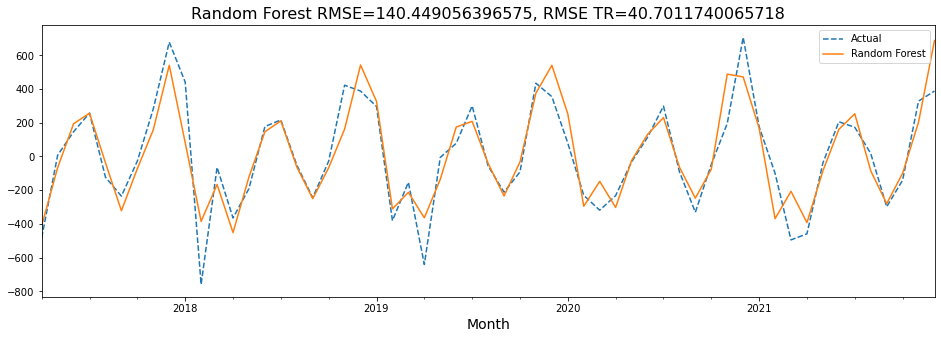

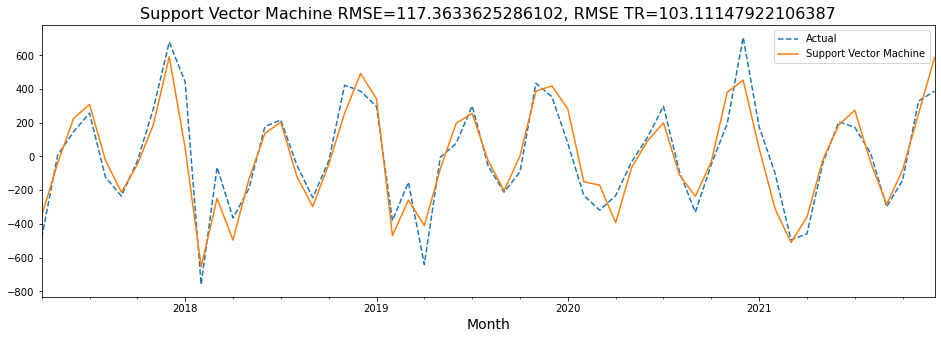

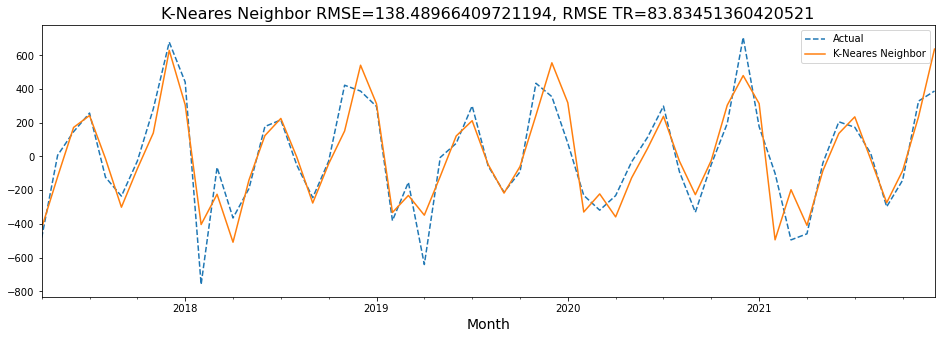

In [336]:
models = {
    'Random Forest': rf,
    'Support Vector Machine': svr,
    'K-Neares Neighbor': knn
}

for name, model in models.items():
    evaluate(y_test, model, name)

In [337]:
lr.coef_

array([-0.4530715 , -0.54837439, -0.52193621, -0.55537246, -0.52252109,
       -0.5314349 , -0.48667664, -0.5335054 , -0.5481227 , -0.5213778 ,
       -0.40118954,  0.30617641])

In [338]:
len(lr.coef_)

12

In [339]:
lr.intercept_

2.6150163240450457

In [121]:
rf.feature_importances_

array([0.28128657, 0.06269294, 0.04806538, 0.03166228, 0.04133109,
       0.03662196, 0.046599  , 0.03261969, 0.05090943, 0.06974729,
       0.08322464, 0.21523972])

## There is more

In [164]:
full_data = df_diff.drop(columns=['y'])
y_actual = df_diff['y']

In [165]:
y_hat = lr.predict(full_data)


In [166]:
residuals = y_actual - y_hat

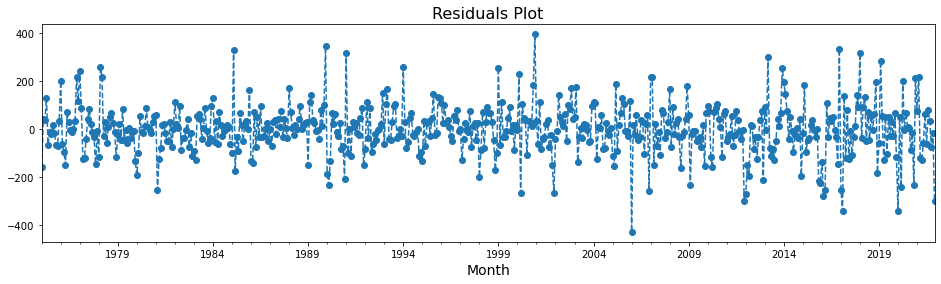

In [167]:
residuals.plot(style='o--', title='Residuals Plot')
plt.savefig('images/fig_12.13.png', bbox_inches='tight')

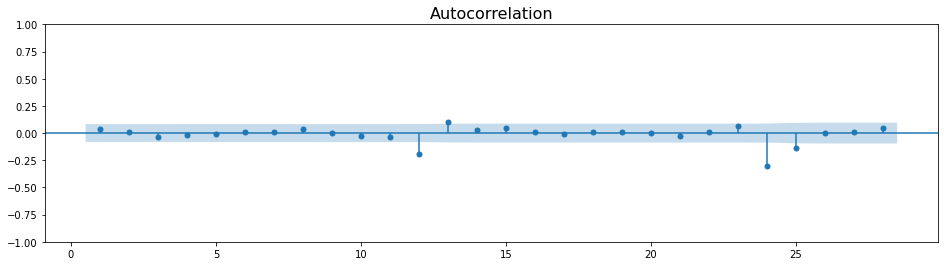

In [174]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, zero=False)
plt.savefig('images/fig_12.14.png', bbox_inches='tight')
plt.show()

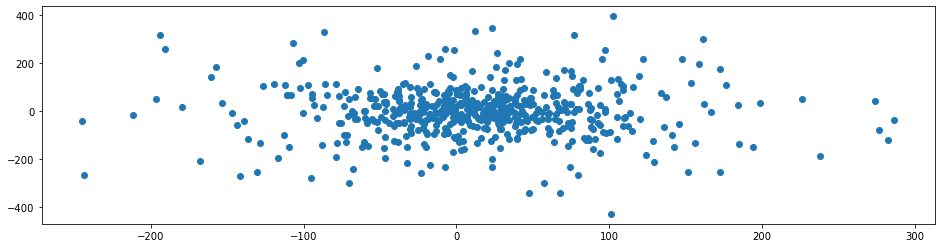

In [175]:
plt.scatter(y_hat, residuals)
plt.savefig('images/fig_12.15.png', bbox_inches='tight')

# Forecasting with sktime

Loading required modules

In [179]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.ensemble import (RandomForestRegressor, 
                              GradientBoostingRegressor, 
                              ExtraTreesRegressor)


from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.all import (
        Deseasonalizer, Detrender, 
        temporal_train_test_split,
        mean_absolute_percentage_error as mape, 
        mean_squared_percentage_error as mspe,
        mean_squared_error as mse, 
        ForecastingHorizon, 
        NaiveForecaster,
        TransformedTargetForecaster,
        PolynomialTrendForecaster
)
from sktime.forecasting.compose import make_reduction
import warnings

warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16, 5))

Importing plotly failed. Interactive plots will not work.


Loading the dataset and inspecting the data

In [180]:
file = Path('../../datasets/Ch12/Residential_Energy_Consumption.xlsx')
col = ['Month','Total Energy Consumed by the Residential Sector']
df = pd.read_excel(file, index_col='Month', usecols=col)
df.columns = ['energy_consumption']

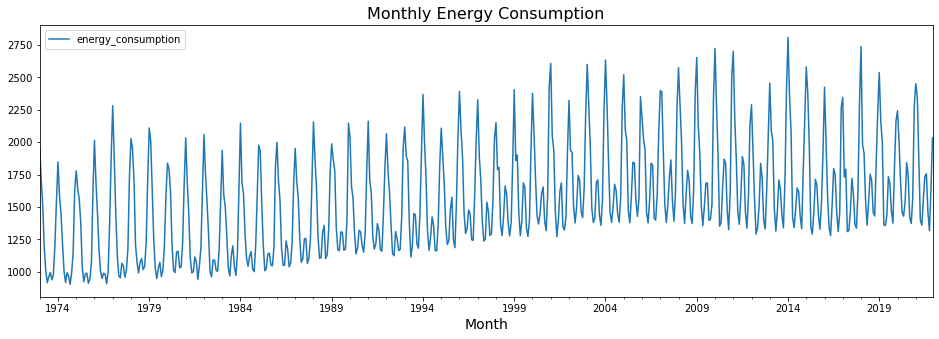

In [181]:
df.plot(title='Monthly Energy Consumption');plt.show()

In [28]:
df.head()

,energy_consumption
Month,
1973-01-01,1957.641
1973-02-01,1712.143
1973-03-01,1510.079
1973-04-01,1183.421
1973-05-01,1006.326


In [29]:
df.tail()

,energy_consumption
Month,
2021-08-01,1755.212
2021-09-01,1456.901
2021-10-01,1315.799
2021-11-01,1644.306
2021-12-01,2032.352


In [30]:
df.index.year.unique()

Int64Index([1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
            1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
            1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
            2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
            2017, 2018, 2019, 2020, 2021],
           dtype='int64', name='Month')

In [31]:
df.shape

(588, 1)

**Different ways to split your time series**


In [32]:
# using sklearn
from sklearn.model_selection import train_test_split
train, teset = train_test_split(df, test_size=24, shuffle=False)

# using sktime 
train, test = temporal_train_test_split(df, test_size=24)

# pandas slicing
size = 24
train, test = df.iloc[:-size], df.iloc[-size:]

train.columns = ['train']
test.columns = ['test']

In [33]:
test

,test
Month,
2020-01-01,2242.462
2020-02-01,2011.541
2020-03-01,1692.834
2020-04-01,1460.650
2020-05-01,1428.359
2020-06-01,1541.875
2020-07-01,1840.435
2020-08-01,1750.274
2020-09-01,1419.171


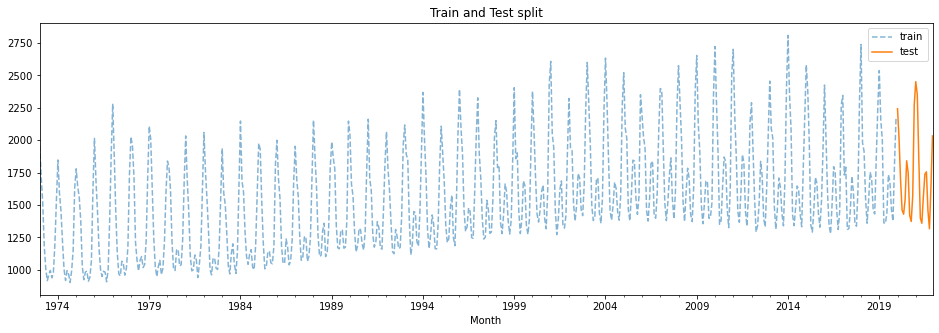

In [34]:
ax = train.plot(style='--', alpha=0.55)
test.plot(ax=ax)
plt.title('Train and Test split')
plt.show()

In [35]:
test.shape

(24, 1)

In [36]:
test.tail()

,test
Month,
2021-08-01,1755.212
2021-09-01,1456.901
2021-10-01,1315.799
2021-11-01,1644.306
2021-12-01,2032.352


In [37]:
from statsmodels.tsa.api import seasonal_decompose, adfuller

In [38]:
adfuller(df)

(-1.449733113243752,
 0.5582151234544165,
 12,
 575,
 {'1%': -3.4417738839904657,
  '5%': -2.8665796253604015,
  '10%': -2.569453974291115},
 6916.6482184861825)

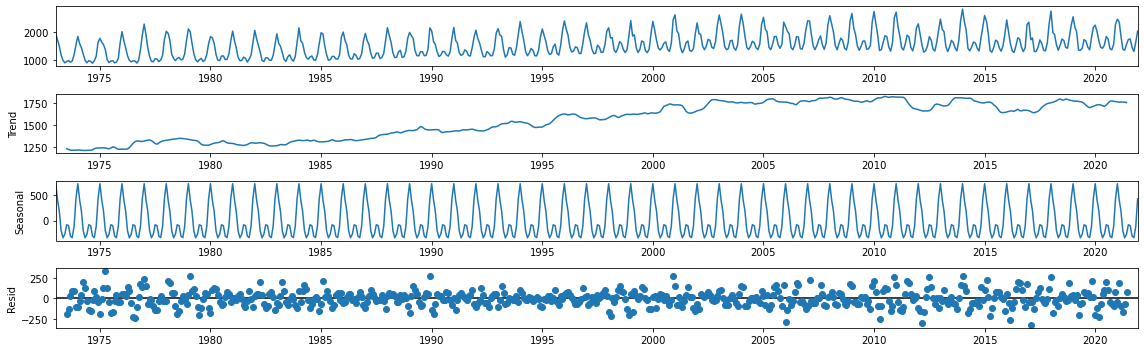

In [39]:
decomposed = seasonal_decompose(df)
decomposed.plot();

In [40]:
test.index

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

In [225]:
def make_forecast(data, n, regressor, window=12):
    fh = ForecastingHorizon(np.arange(n) + 1, is_relative=True)
    forecaster = [
            ("deseasonalize", Deseasonalizer(sp=12, model="additive")),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1)))]
    if not isinstance(regressor, NaiveForecaster):
        reg = ("forecaster", make_reduction(
            regressor,
            strategy='recursive',
            window_length=window,
            scitype='tabular-regressor'))
        forecaster.append(reg)
        model = TransformedTargetForecaster(forecaster).fit(data.values)
        
    else:
        model = regressor.fit(data.values)
    
    predicted = pd.Series(
            model.predict(fh=fh).reshape(-1),
            index= test.index
                    )
    return predicted

In [42]:
regressors = {
            'Naive Forecaster' : NaiveForecaster(strategy='mean', sp=12),
            'Linear Regression': LinearRegression(),
            'K-NN Regressor': KNeighborsRegressor(n_neighbors=5),
            'Extra Tree Regressor': ExtraTreesRegressor(),
            'Random Forest Regressor': RandomForestRegressor(),
            'Gradient Boosting Regressor': GradientBoostingRegressor()
            }

for k, reg in regressors.items():
    print(f'training {reg} ...')
    test[k] = make_forecast(train, len(test), regressor=reg , window=15)

training NaiveForecaster(sp=12, strategy='mean') ...
training LinearRegression() ...
training KNeighborsRegressor() ...
training ExtraTreesRegressor() ...
training RandomForestRegressor() ...
training GradientBoostingRegressor() ...


In [43]:
test.shape

(24, 7)

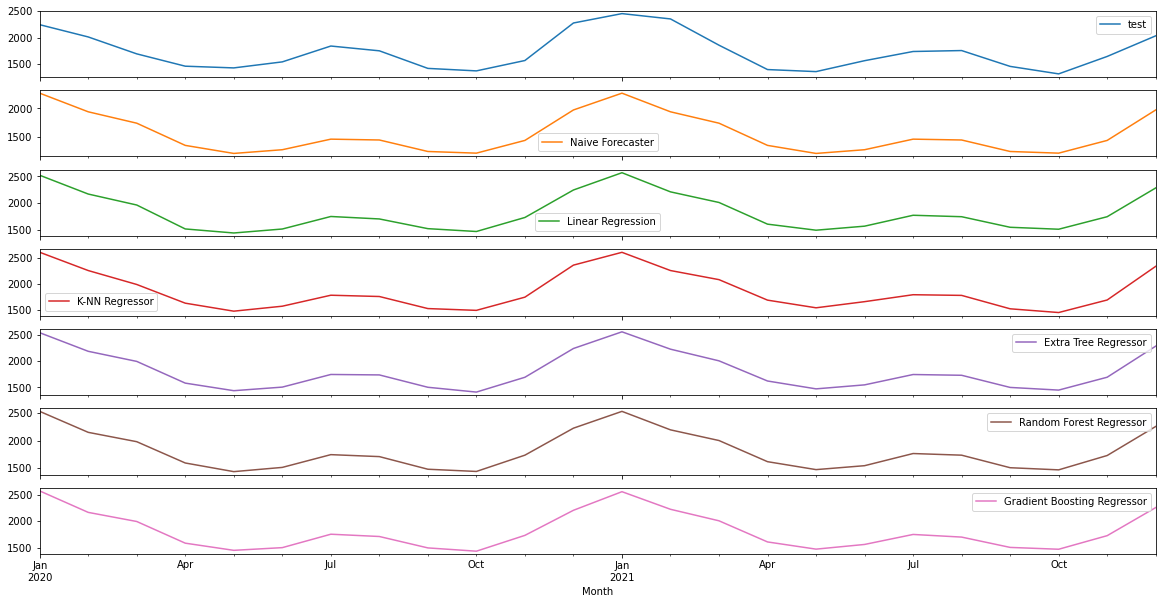

In [44]:
test.plot(subplots=True, figsize=(20, 10));plt.show()

<AxesSubplot:xlabel='Month'>

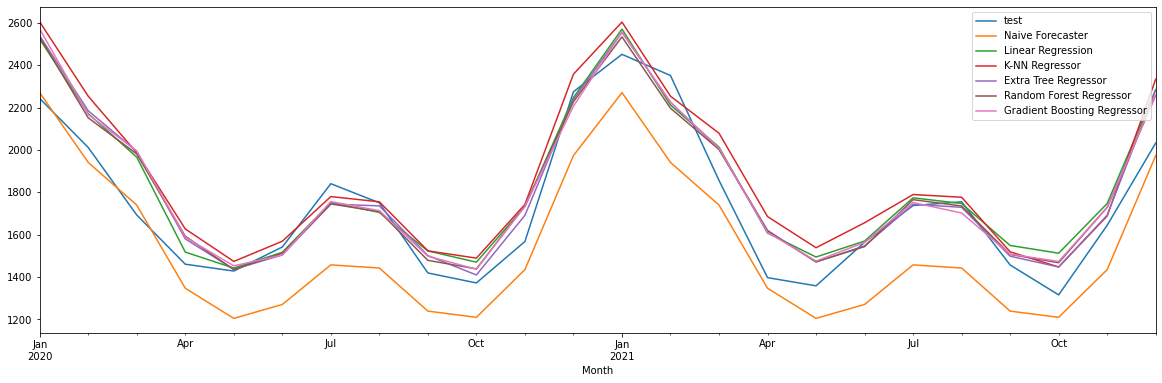

In [45]:
test.plot(subplots=False, figsize=(20, 6))

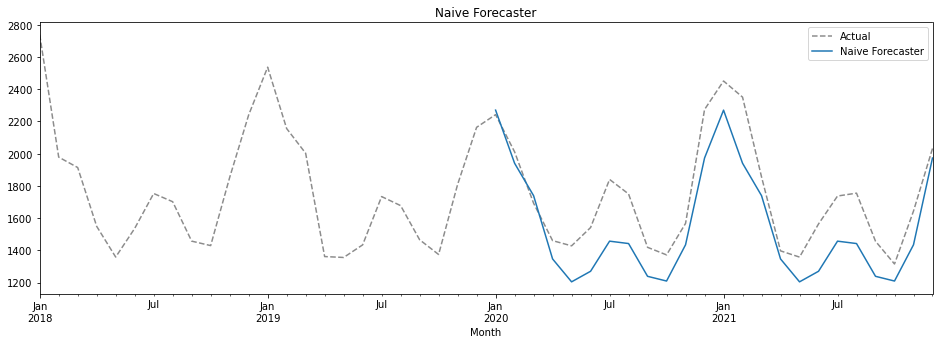

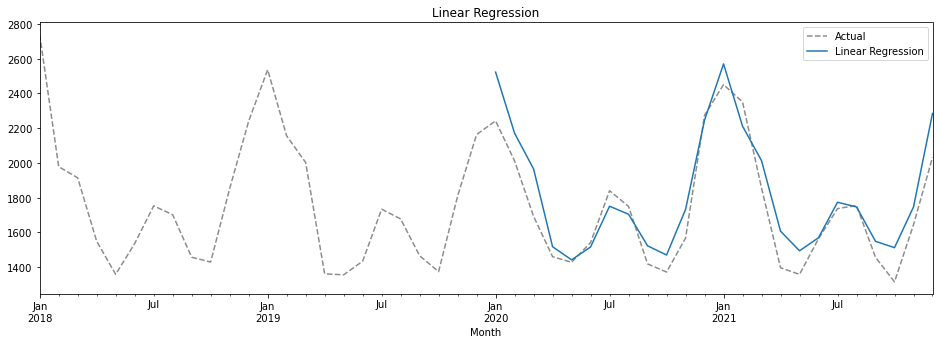

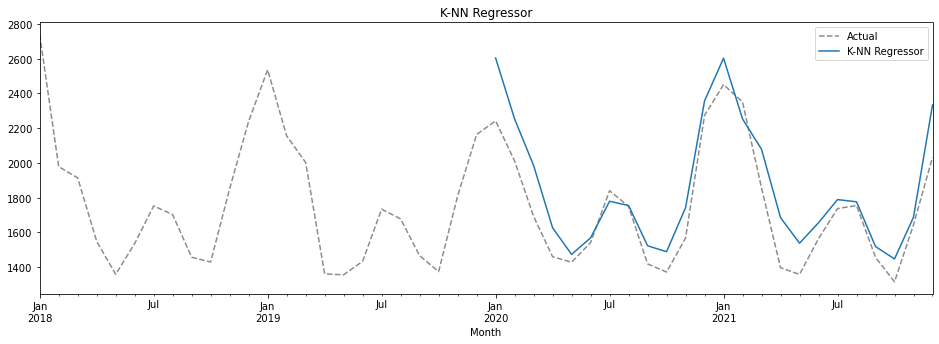

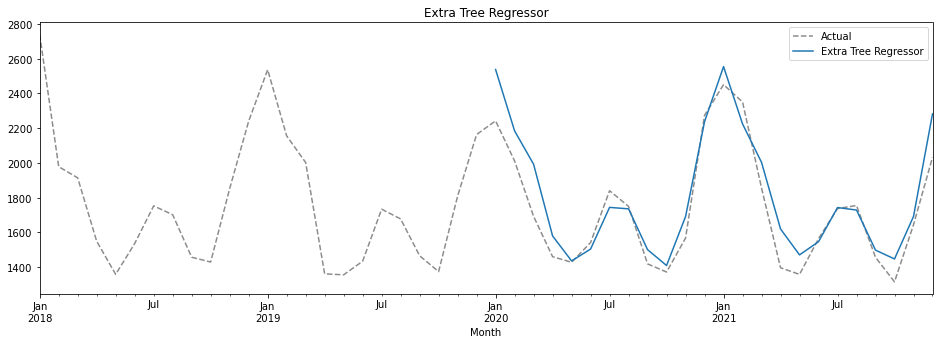

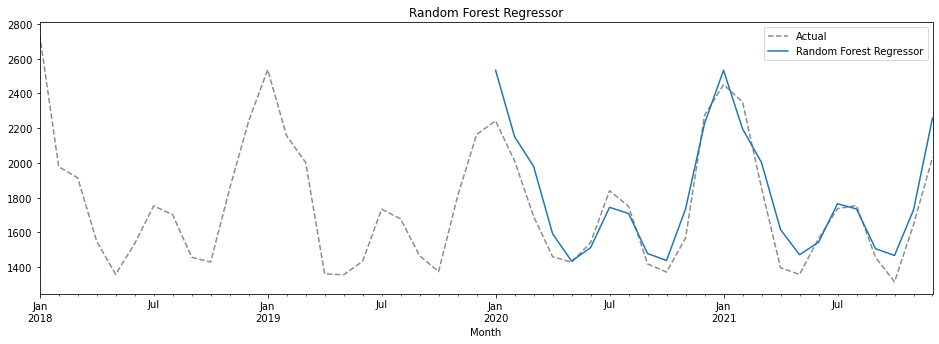

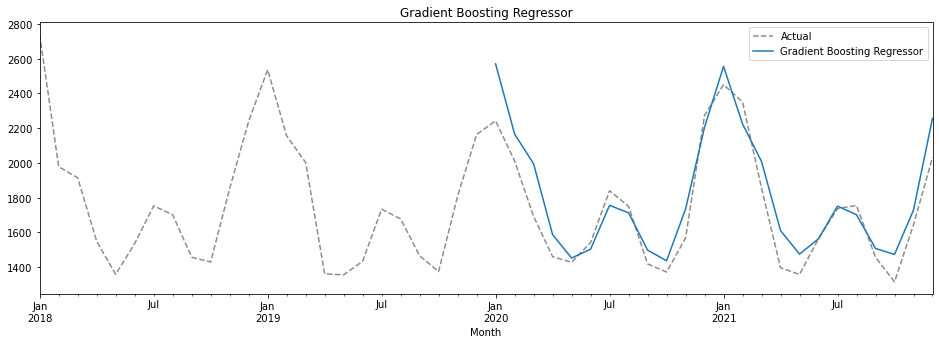

In [46]:
for i in test.iloc[: , 1:]:
    ax = df[-2*len(test):].plot(style='k--', alpha=0.45, title=i)
    test[i].plot(ax=ax)
    plt.legend(['Actual', i])
    plt.show()

In [226]:
def evaluate(df, sort_by='sMAPE'):
    evals = pd.DataFrame(index=['sMAPE', 'MAPE', 'RMSE'])
    y_truth = df['test']
    y_predicted = df.drop(columns=['test'])
    for p in y_predicted:
        evals.loc['sMAPE', p] = mape(y_truth, y_predicted[p], symmetric=True)
        evals.loc['MAPE', p] = mape(y_truth, y_predicted[p], symmetric=False)
        evals.loc['RMSE', p] = np.sqrt(mse(y_truth, y_predicted[p]))
    return evals.T.sort_values(by=sort_by)
    

In [48]:
evaluate(test)

,sMAPE,MAPE,RMSE
Extra Tree Regressor,0.058853,0.061459,137.371526
Random Forest Regressor,0.061911,0.064536,137.417509
Gradient Boosting Regressor,0.064279,0.067125,142.967258
Linear Regression,0.065325,0.068308,142.176939
K-NN Regressor,0.076512,0.080899,170.178191
Naive Forecaster,0.121355,0.112677,219.987776


In [49]:
evaluate(test, sort_by='RMSE')

,sMAPE,MAPE,RMSE
Extra Tree Regressor,0.058853,0.061459,137.371526
Random Forest Regressor,0.061911,0.064536,137.417509
Linear Regression,0.065325,0.068308,142.176939
Gradient Boosting Regressor,0.064279,0.067125,142.967258
K-NN Regressor,0.076512,0.080899,170.178191
Naive Forecaster,0.121355,0.112677,219.987776


## There is more

In [28]:
from pmdarima import auto_arima
n = len(test)
fh = ForecastingHorizon(np.arange(n) + 1)
arima = auto_arima(y=train, seasonal=True, m=12, suppress_warnings=True)

In [29]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  564
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood               -3338.554
Date:                                 Fri, 08 Apr 2022   AIC                           6691.108
Time:                                         03:27:28   BIC                           6721.441
Sample:                                              0   HQIC                          6702.949
                                                 - 564                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.006      0.106      0.916      -0.011       0.012
ar.L1          0.4767      0.034     14.071      0.000       0.410       0.543
ma.L1         -0.9748      0.010   -102.212      0.000      -0.993      -0.956
ar.S.L12       0.9978      0.002    612.650      0.000       0.995       1.001
ma.S.L12      -0.7217      0.028    -25.434      0.000      -0.777      -0.666
ma.S.L24      -0.0871      0.012     -7.308      0.000      -0.110      -0.064
sigma2      7804.8584    340.564     22.917      0.000    7137.366    8472.351
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):                97.61
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               2.20   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
test['ARIMA'] = arima.predict(n)

In [31]:
test.shape

(24, 8)

In [32]:
test.head()

,test,Naive Forecaster,Linear Regression,K-NN Regressor,Extra Tree Regressor,Random Forest Regressor,Gradient Boosting Regressor,ARIMA
Month,,,,,,,,
2020-01-01,2242.462,2270.323702,2522.814708,2604.277175,2528.933594,2536.450796,2570.473160,2506.947375
2020-02-01,2011.541,1940.863681,2171.116655,2253.460503,2178.930967,2151.040212,2166.817111,2084.300249
2020-03-01,1692.834,1739.600298,1965.760283,1985.997768,1977.476754,1952.271006,1995.332132,1900.006095
2020-04-01,1460.650,1347.089489,1517.825403,1627.154399,1594.253255,1584.834951,1587.730558,1407.773645
2020-05-01,1428.359,1204.958617,1442.385026,1473.659183,1433.401763,1442.829907,1452.865700,1347.337206


In [33]:
evaluate(test)

,sMAPE,MAPE,RMSE
ARIMA,0.042925,0.043336,108.738816
Extra Tree Regressor,0.061623,0.064157,135.904756
Random Forest Regressor,0.061705,0.064394,138.827577
Gradient Boosting Regressor,0.064279,0.067125,142.967258
Linear Regression,0.065325,0.068308,142.176939
K-NN Regressor,0.076512,0.080899,170.178191
Naive Forecaster,0.121355,0.112677,219.987776


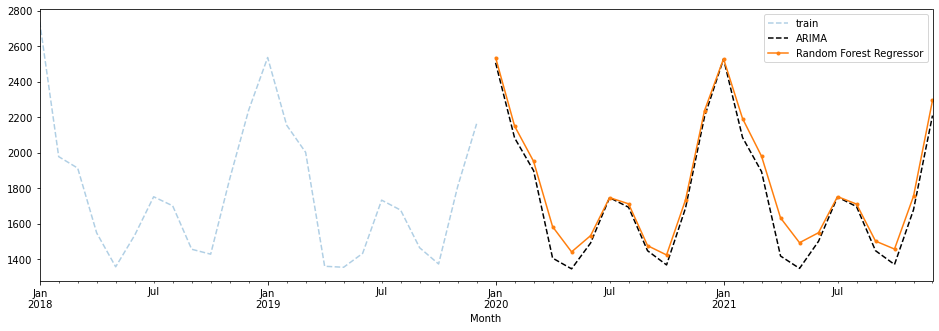

In [34]:
ax = train.loc['2018':].plot(style='--', alpha=0.35)
test['ARIMA'].plot(ax=ax, style='k--')
test['Random Forest Regressor'].plot(ax=ax, style='.-')
# test['Naive Forecaster'].plot(ax=ax, style='.-')
plt.legend()

## Manual

## How it Works

```python
make_reduction(estimator, 
               strategy='recursive', 
               window_length=10, 
               scitype='infer')
```

# Optimizing a Machine Learning model with Hyperparameter Tuning

In [184]:
from sktime.forecasting.all import (
        ForecastingGridSearchCV, 
        SlidingWindowSplitter,
        MeanAbsolutePercentageError)

In [31]:
file = Path('../../datasets/Ch12/Residential_Energy_Consumption.xlsx')
col = ['Month','Total Energy Consumed by the Residential Sector']
df = pd.read_excel(file, index_col='Month', usecols=col)
df.columns = ['energy_consumption']

In [32]:
train, test = temporal_train_test_split(df, test_size=24)
train.columns = ['train']
test.columns = ['test']
train.shape

(564, 1)

In [33]:
test.shape

(24, 1)

In [34]:
n = len(test)
fh = ForecastingHorizon(np.arange(n) + 1, is_relative=True)
forecaster = TransformedTargetForecaster(
    [("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
     ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
     ("forecast",
            make_reduction(
                RandomForestRegressor(),
                scitype="tabular-regressor",
                window_length=12,
                strategy="recursive",
            ), ),  ])

In [35]:
forecaster.fit(train.values)
test['RandomForestRegressor'] = forecaster.predict(fh)

In [36]:
test.head()

,test,RandomForestRegressor
Month,,
2020-01-01,2242.462,2567.523434
2020-02-01,2011.541,2198.274815
2020-03-01,1692.834,1962.437646
2020-04-01,1460.650,1513.020806
2020-05-01,1428.359,1375.816806


In [37]:
evaluate(test)

,sMAPE,MAPE,RMSE
RandomForestRegressor,0.062807,0.065323,144.288861


In [38]:
forecaster.get_params()

{'steps': [('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
  ('detrend', Detrender(forecaster=PolynomialTrendForecaster())),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                        window_length=12))],
 'deseasonalize': Deseasonalizer(model='multiplicative', sp=12),
 'detrend': Detrender(forecaster=PolynomialTrendForecaster()),
 'forecast': RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                      window_length=12),
 'deseasonalize__model': 'multiplicative',
 'deseasonalize__sp': 12,
 'detrend__forecaster__degree': 1,
 'detrend__forecaster__regressor': None,
 'detrend__forecaster__with_intercept': True,
 'detrend__forecaster': PolynomialTrendForecaster(),
 'forecast__estimator__bootstrap': True,
 'forecast__estimator__ccp_alpha': 0.0,
 'forecast__estimator__criterion': 'squared_error',
 'forecast__estimator__max_depth': None,
 'forecast__estima

In [39]:
forecaster.get_params().keys()

dict_keys(['steps', 'deseasonalize', 'detrend', 'forecast', 'deseasonalize__model', 'deseasonalize__sp', 'detrend__forecaster__degree', 'detrend__forecaster__regressor', 'detrend__forecaster__with_intercept', 'detrend__forecaster', 'forecast__estimator__bootstrap', 'forecast__estimator__ccp_alpha', 'forecast__estimator__criterion', 'forecast__estimator__max_depth', 'forecast__estimator__max_features', 'forecast__estimator__max_leaf_nodes', 'forecast__estimator__max_samples', 'forecast__estimator__min_impurity_decrease', 'forecast__estimator__min_samples_leaf', 'forecast__estimator__min_samples_split', 'forecast__estimator__min_weight_fraction_leaf', 'forecast__estimator__n_estimators', 'forecast__estimator__n_jobs', 'forecast__estimator__oob_score', 'forecast__estimator__random_state', 'forecast__estimator__verbose', 'forecast__estimator__warm_start', 'forecast__estimator', 'forecast__window_length'])

In [223]:
# large grid search space
hyperparams_grid = {
    "forecast__estimator__n_estimators": [100, 300, 500, 1000],
    "deseasonalize__model": ['multiplicative', 'additive'],
    "forecast__estimator__max_depth": [None] + [int(x) for x in np.linspace(2, 20, num = 10)],
    "forecast__estimator__min_samples_split": [2, 5, 7],
    "forecast__estimator__min_samples_leaf": [1, 2, 4],
    "forecast__estimator__bootstrap": [True, False],
    "forecast__window_length": [10, 12, 15],
    "forecast__estimator__ccp_alpha": [0.0, 0.005, 0.01]
}

In [40]:
#smaller grid search space
hyperparams_grid = {
    "forecast__estimator__n_estimators": [100, 500],
    "forecast__estimator__max_depth": [None, 2, 4],
    "forecast__estimator__min_samples_split": [2, 3, 5],
    "forecast__window_length": [10, 12, 15],
}


cv = SlidingWindowSplitter(window_length=int(len(df) * 0.90), fh=fh)
smape = MeanAbsolutePercentageError(symmetric=True)

grid_csv = ForecastingGridSearchCV(
    forecaster, 
    strategy="refit", 
    cv=cv, 
    param_grid=hyperparams_grid, 
    scoring=smape,
    return_n_best_forecasters=1,
    verbose=1
)

In [41]:
grid_csv.cv

SlidingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24],
           dtype='int64', is_relative=True),
           window_length=529)

In [203]:
grid_csv.fit(df.values)

Fitting 36 folds for each of 54 candidates, totalling 1944 fits


ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24],
           dtype='int64', is_relative=True),
           window_length=529),
                        forecaster=TransformedTargetForecaster(steps=[('deseasonalize',
                                                                       Deseasonalizer(model='multiplicative',
                                                                                      sp=12)),
                                                                      ('detrend',
                                                                       Detrender()),
                                                                      ('forecast',
                                                                       RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                                         

In [211]:
grid_csv.best_forecaster_

TransformedTargetForecaster(steps=[('deseasonalize',
                                    Deseasonalizer(model='multiplicative',
                                                   sp=12)),
                                   ('detrend', Detrender()),
                                   ('forecast',
                                    RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(max_depth=4,
                                                                                                         min_samples_split=5,
                                                                                                         n_estimators=500),
                                                                         window_length=12))])

In [212]:
grid_csv.best_params_

{'forecast__estimator__max_depth': 4,
 'forecast__estimator__min_samples_split': 5,
 'forecast__estimator__n_estimators': 500,
 'forecast__window_length': 12}

In [227]:
grid_csv.cv_results_

In [214]:
test['RandomForestRegressor_optim'] = grid_csv.predict(fh)

In [215]:
evaluate(test)

,sMAPE,MAPE,RMSE
RandomForestRegressor_optim,0.052736,0.054957,128.603376
RandomForestRegressor,0.061285,0.063601,137.970780


In [216]:
model = grid_csv.best_forecaster_

In [217]:
model.get_params() 

{'steps': [('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
  ('detrend', Detrender()),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(max_depth=4,
                                                                        min_samples_split=5,
                                                                        n_estimators=500),
                                        window_length=12))],
 'deseasonalize': Deseasonalizer(model='multiplicative', sp=12),
 'detrend': Detrender(),
 'forecast': RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(max_depth=4,
                                                                      min_samples_split=5,
                                                                      n_estimators=500),
                                      window_length=12),
 'deseasonalize__model': 'multiplicative',
 'deseasonalize__sp': 12,
 'detrend__forecaster': None,
 'forecast__estimator__bootst

# Multivariate Forecasting and Ensemble Learning with sktime

In [246]:
from sktime.forecasting.all import EnsembleForecaster
from sklearn.svm import SVR
from sktime.transformations.series.detrend import ConditionalDeseasonalizer
from sktime.datasets import load_macroeconomic

In [247]:
load_macroeconomic().shape

(203, 12)

In [248]:
econ = load_macroeconomic()
cols = ['realgdp','realdpi','tbilrate', 'unemp', 'infl']
econ_df = econ[cols]

In [249]:
econ_df.shape

(203, 5)

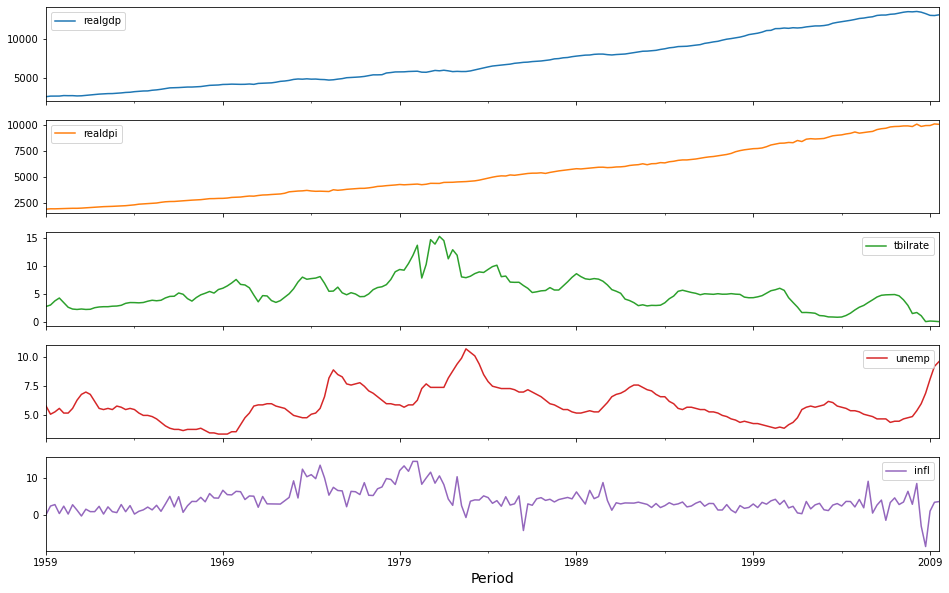

In [250]:
econ_df.plot(subplots=True, figsize=(16, 10));plt.show()

## How to do it

In [251]:
econ_df.head()

,realgdp,realdpi,tbilrate,unemp,infl
Period,,,,,
1959Q1,2710.349,1886.9,2.82,5.8,0.00
1959Q2,2778.801,1919.7,3.08,5.1,2.34
1959Q3,2775.488,1916.4,3.82,5.3,2.74
1959Q4,2785.204,1931.3,4.33,5.6,0.27
1960Q1,2847.699,1955.5,3.50,5.2,2.31


In [252]:
cond_deseason = ConditionalDeseasonalizer(sp=4)
detrend = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
for col in econ_df:
    econ_df[col] = cond_deseason.fit_transform(econ_df[col])
    econ_df[col] = detrend.fit_transform(econ_df[col])

In [253]:
y = econ_df['unemp']
exog = econ_df.drop(columns=['unemp'])

In [254]:
test_size = 12
y_train, y_test = temporal_train_test_split(y, test_size=test_size)
exog_train, exog_test = temporal_train_test_split(exog, test_size=test_size)

In [255]:
regressors = [
        ("LinearRegression", make_reduction(LinearRegression())),
        ("RandomForest", make_reduction(RandomForestRegressor())),
        ("SupportVectorRegressor", make_reduction(SVR())),
        ("GradientBoosting", make_reduction(GradientBoostingRegressor()))
    ]

In [256]:
ensemble = EnsembleForecaster(regressors)
rf = make_reduction(RandomForestRegressor())

In [257]:
ensemble.fit(y=y_train, X=exog_train)
rf.fit(y=y_train, X=exog_train)

RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor())

In [258]:
fh = ForecastingHorizon(y_test.index, is_relative=None)

y_hat = pd.DataFrame(y_test).rename(columns={'unemp': 'test'})
y_hat['EnsembleForecaster'] = ensemble.predict(fh=fh, X=exog_test)
y_hat['RandomForest'] = rf.predict(fh=fh, X=exog_test)

In [261]:
evaluate(y_hat)

,sMAPE,MAPE,RMSE
RandomForest,0.965133,8.666123,2.338473
EnsembleForecaster,1.051301,3.828983,1.702995


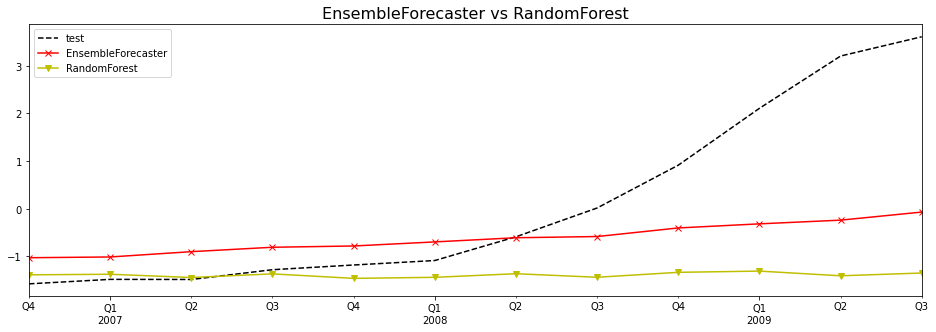

In [265]:
styles = ['k--','rx-','yv-']
for col, s in zip(y_hat, styles):
    y_hat[col].plot(style=s, label=col, 
                    title='EnsembleForecaster vs RandomForest')
plt.legend()
plt.savefig('images/fig_12.24.png', bbox_inches='tight', dpi=300)
plt.show()

In [501]:
multi_grid.best_params_

{'selected_forecaster': 'GradientBoosting'}

In [500]:
multi_grid.cv_results_

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.287071,0.016769,0.006967,{'selected_forecaster': 'LinearRegression'},3.0
1,0.108129,0.305849,0.068155,{'selected_forecaster': 'RandomForest'},2.0
2,0.303801,0.015557,0.006060,{'selected_forecaster': 'SupportVectorRegressor'},4.0
3,0.105496,0.190713,0.007355,{'selected_forecaster': 'GradientBoosting'},1.0


## There is more

In [282]:
regressors

[('LinearRegression',
  RecursiveTabularRegressionForecaster(estimator=LinearRegression())),
 ('RandomForest',
  RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor())),
 ('SupportVectorRegressor',
  RecursiveTabularRegressionForecaster(estimator=SVR())),
 ('GradientBoosting',
  RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor()))]

In [283]:
from sktime.forecasting.compose import AutoEnsembleForecaster

auto = AutoEnsembleForecaster(forecasters=regressors,
                             method='feature-importance')
auto.fit(y=y_train, X=exog_train)

AutoEnsembleForecaster(forecasters=[('LinearRegression',
                                     RecursiveTabularRegressionForecaster(estimator=LinearRegression())),
                                    ('RandomForest',
                                     RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor())),
                                    ('SupportVectorRegressor',
                                     RecursiveTabularRegressionForecaster(estimator=SVR())),
                                    ('GradientBoosting',
                                     RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor()))])

In [284]:
auto.weights_

[0.1992846306188651,
 0.17097181125615227,
 0.38045734892465477,
 0.24928620920032785]

In [285]:
y_hat['AutoEnsembleForecaster'] = auto.predict(fh=fh, X=exog_test)

In [276]:
evaluate(y_hat)

,sMAPE,MAPE,RMSE
RandomForest,0.965133,8.666123,2.338473
AutoEnsembleForecaster,1.004482,10.847680,2.574099
EnsembleForecaster,1.051301,3.828983,1.702995
